In [4]:
import math

# import modules automatically after changes
%load_ext autoreload
%autoreload 2
# Show plots in the notebook
%matplotlib inline

# Imports

In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import isoweek
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import math

from src.utils import load_config

In [192]:
# Set plot style
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 14
%config InlineBackend.figure_format = 'retina'
# Set color palette

# Load data

In [11]:
# # set working directory to project root - EXECUTE ONLY ONCE or RESTART KERNEL
# os.chdir('..')
os.getcwd()

'C:\\Users\\merti\\PycharmProjects\\sem-outbreak-detection'

In [15]:
# Load configs
config = load_config("config.yaml")

In [218]:
# Get data
df_recently_puplished = pd.read_csv(
    config["data"]["data_recently_puplished"],
    encoding="UTF-16",
    sep="\t",  # tab as separator
    index_col=0,
    header=1,
    skipinitialspace=True,  # skip spaces after delimiter/separator
    engine="python",  # use python engine
)
# Remove trailing spaces in column names
df_recently_puplished.columns = df_recently_puplished.columns.str.strip()

# Data Description
= **Norovirus** gastroenteritis & rotavirus** gastroenteritis reports in accordance with the Infection Protection Act (§7.1 IfSG and §7.3 IfSG).

**Data Source**: [RKI SurvStat](https://survstat.rki.de/Content/Query/Create.aspx)
**Data Collection/Reporting**: Data was collected and forwarded via health authorities and regional offices.
**Data Structure**:
* Data is sorted according to the seasonal calendar (KW27 to KW26 of the following year). Reason: The seasonal division (starting KW27) is adapted to the epidemiological season of notification obligation, as rotavirus gastroenteritis typically shows seasonal patterns like others.
* **x: Season year (e.g. 2024/2025)**, starting from KW27. Corresponds to the seasonal calendar, in which reporting takes place from summer to summer. Indicates when the health department first officially became aware of a case through notification or its own investigation. "Saisonjahr (beginnend mit KW27), in der das Gesundheitsamt erstmalig, durch Meldung oder eigene Ermittlung, offizielle Kenntnis von einem Fall erlangt."
* **y: Season week (SW1 corresponds to KW27 of the seasonal calendar)**. Indicates in which calendar week the case first became known. " Saisonwoche (SW1 = KW27), in der das Gesundheitsamt erstmalig, durch Meldung oder eigene Ermittlung, offizielle Kenntnis von einem Fall erlangt.
"

--> **Indicates the number of new cases officially reported in the respective season week and season year.**

**Note**: Only the first report of a case is counted, thus it does not represent the total number of cases currently present in the respective season week.

**NaN values explanation:**
* 2000/2001: Recording did not yet exist.
* SW53: seasonal week 53 does not exist in every seasonal year, corresponding to the calender year, where the number of weeks in a year can vary between 52 and 53 (due to counting method according to ISO 8601): A year has exactly 53 weeks if it starts or ends on a Thursday.
* 20224/2025: Data is not yet available since the season is still ongoing.


In [17]:
df_recently_puplished.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 2000/01 to 2024/25
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SW01    24 non-null     float64
 1   SW02    24 non-null     float64
 2   SW03    24 non-null     float64
 3   SW04    24 non-null     float64
 4   SW05    24 non-null     float64
 5   SW06    24 non-null     float64
 6   SW07    24 non-null     float64
 7   SW08    24 non-null     float64
 8   SW09    24 non-null     float64
 9   SW10    24 non-null     float64
 10  SW11    24 non-null     float64
 11  SW12    24 non-null     float64
 12  SW13    24 non-null     float64
 13  SW14    24 non-null     float64
 14  SW15    24 non-null     float64
 15  SW16    24 non-null     float64
 16  SW17    24 non-null     float64
 17  SW18    24 non-null     float64
 18  SW19    24 non-null     float64
 19  SW20    24 non-null     float64
 20  SW21    24 non-null     float64
 21  SW22    24 non-null     float64
 22

In [18]:
df_recently_puplished.head(10)

,SW01,SW02,SW03,SW04,SW05,SW06,SW07,SW08,SW09,SW10,...,SW44,SW45,SW46,SW47,SW48,SW49,SW50,SW51,SW52,SW53
2000/01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1486.0,1507.0,1314.0,993.0,952.0,684.0,709.0,655.0,574.0,NaN
2001/02,430.0,362.0,280.0,268.0,232.0,236.0,237.0,213.0,202.0,239.0,...,2165.0,1632.0,1596.0,980.0,846.0,795.0,698.0,574.0,421.0,NaN
2002/03,405.0,451.0,448.0,512.0,318.0,305.0,312.0,301.0,367.0,253.0,...,2129.0,2060.0,1634.0,1299.0,886.0,784.0,515.0,490.0,469.0,NaN
2003/04,437.0,409.0,423.0,398.0,326.0,297.0,263.0,309.0,310.0,301.0,...,2070.0,1815.0,1521.0,1125.0,1054.0,844.0,912.0,830.0,673.0,NaN
2004/05,535.0,519.0,550.0,484.0,514.0,437.0,550.0,494.0,549.0,539.0,...,3153.0,2383.0,2284.0,1851.0,1952.0,1602.0,1299.0,1167.0,991.0,809.0
2005/06,529.0,469.0,447.0,358.0,305.0,300.0,309.0,324.0,340.0,293.0,...,2096.0,2044.0,2001.0,1436.0,1460.0,1044.0,1123.0,837.0,633.0,NaN
2006/07,652.0,473.0,455.0,402.0,362.0,378.0,480.0,353.0,418.0,395.0,...,4159.0,5014.0,4270.0,4226.0,2571.0,2023.0,1713.0,1159.0,956.0,NaN
2007/08,784.0,911.0,706.0,722.0,652.0,540.0,598.0,681.0,676.0,680.0,...,3707.0,4011.0,3081.0,2717.0,2674.0,1879.0,1443.0,1320.0,1171.0,NaN
2008/09,998.0,867.0,858.0,669.0,639.0,729.0,664.0,730.0,707.0,832.0,...,2970.0,3464.0,2895.0,2096.0,1923.0,1225.0,1246.0,1241.0,1193.0,NaN
2009/10,917.0,917.0,767.0,679.0,642.0,663.0,723.0,746.0,787.0,817.0,...,5661.0,5251.0,3722.0,4024.0,3119.0,2731.0,2664.0,1970.0,1530.0,1427.0


In [19]:
# Drop season 2000/2001 and 2024/2025 due to missing data (index)
df_recently_puplished = df_recently_puplished.drop(["2000/01", "2024/25"])

# Data Preparation

In [20]:
# Stack data
df_temp = df_recently_puplished.stack(future_stack=True).reset_index()
df_temp.columns = ["seasonYear", "seasonWeek", "reports"]
df_temp["seasonWeek"] = df_temp["seasonWeek"].str.replace("SW", "").astype(int)
df_temp

,seasonYear,seasonWeek,reports
0,2001/02,1,430.0
1,2001/02,2,362.0
2,2001/02,3,280.0
3,2001/02,4,268.0
4,2001/02,5,232.0
...,...,...,...
1214,2023/24,49,1370.0
1215,2023/24,50,1269.0
1216,2023/24,51,1238.0
1217,2023/24,52,1100.0


Map seasonal week to single datetime-like index for the weekly data

In [21]:
# 2000/01 SW1-SW27 = 2001 KW 27-53, 2000/01 SW28-SW53 = 2002 KW 1-26
def map_seasonal_calendar_to_calendar(seasonYear, seasonWeek):
    """
    Map a seasonal calendar week to the corresponding calendar year and week.

    :param seasonYear: str, seasonal year in the format "YYYY/YYYY" (e.g., "2000/2001")
    :param seasonWeek: int, seasonal week (1-53)
    :return: tuple, (calendarYear: int or np.nan, calendarWeek: int or np.nan)
    """
    first_year, second_year = seasonYear.split("/")
    max_week_first_year = isoweek.Week.last_week_of_year(int(first_year)).week

    # Handle SW1-27 (~ KW 27-53 of first year)
    if seasonWeek <= 27:
        calendarWeek = seasonWeek + 26
        if (
            calendarWeek > max_week_first_year
        ):  # Handle overflow to second year (if first year has only 52 weeks)
            return first_year[:2] + second_year, 1
        return first_year, calendarWeek

    # Handle SW28-53 (~ KW 1-26 of second year)
    elif 28 <= seasonWeek <= 53:
        if (
            max_week_first_year == 52 and seasonWeek == 53
        ):  # Invalid SW53 (if first year has only 52 weeks)
            return np.nan, np.nan
        return first_year[:2] + second_year, seasonWeek - (max_week_first_year - 26)

    # Handle invalid seasonWeek (not in range 1-53)
    return np.nan, np.nan

In [22]:
# Get calendar year and week
df_temp[["calendarYear", "calendarWeek"]] = df_temp.apply(
    lambda x: pd.Series(
        map_seasonal_calendar_to_calendar(x["seasonYear"], x["seasonWeek"])
    ),
    axis=1,
)

In [23]:
# Get week start date as datetime like index
def calculate_week_start_date(calendar_year, calendar_week):
    """
    Calculate the Monday (start date) of a given calendar week in the ISO calendar.

    :param calendar_year: int, calendar year
    :param calendar_week: int, calendar week
    :return: datetime, start date of the week
    """
    try:
        return datetime.strptime(
            f"{int(calendar_year)}-W{int(calendar_week)}-1", "%G-W%V-%u"
        )
    except ValueError:
        return np.nan

In [24]:
df_temp["week_start_date"] = df_temp.apply(
    lambda x: calculate_week_start_date(x["calendarYear"], x["calendarWeek"]), axis=1
)

In [25]:
df_temp

,seasonYear,seasonWeek,reports,calendarYear,calendarWeek,week_start_date
0,2001/02,1,430.0,2001,27.0,2001-07-02
1,2001/02,2,362.0,2001,28.0,2001-07-09
2,2001/02,3,280.0,2001,29.0,2001-07-16
3,2001/02,4,268.0,2001,30.0,2001-07-23
4,2001/02,5,232.0,2001,31.0,2001-07-30
...,...,...,...,...,...,...
1214,2023/24,49,1370.0,2024,23.0,2024-06-03
1215,2023/24,50,1269.0,2024,24.0,2024-06-10
1216,2023/24,51,1238.0,2024,25.0,2024-06-17
1217,2023/24,52,1100.0,2024,26.0,2024-06-24


Handling remaining NaN values

In [26]:
# df_cleaned = df_temp.dropna() # drop all rows with NaN values (e.g., invalid SW53)
df_cleaned = df_temp[
    df_temp["seasonWeek"] != 53
]  # drop all data of seasonal weeks 53 (not available in every year)

In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1196 entries, 0 to 1217
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   seasonYear       1196 non-null   object        
 1   seasonWeek       1196 non-null   int64         
 2   reports          1196 non-null   float64       
 3   calendarYear     1196 non-null   object        
 4   calendarWeek     1196 non-null   float64       
 5   week_start_date  1196 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 65.4+ KB


In [28]:
# Update dtypes
df_cleaned = df_cleaned.astype(
    {
        "seasonYear": "str",
        "seasonWeek": "int",
        "calendarYear": "int",
        "calendarWeek": "int",
        "reports": "int",
        "week_start_date": "datetime64[ns]",
    }
)

In [29]:
df_cleaned.head(10)

,seasonYear,seasonWeek,reports,calendarYear,calendarWeek,week_start_date
0,2001/02,1,430,2001,27,2001-07-02
1,2001/02,2,362,2001,28,2001-07-09
2,2001/02,3,280,2001,29,2001-07-16
3,2001/02,4,268,2001,30,2001-07-23
4,2001/02,5,232,2001,31,2001-07-30
5,2001/02,6,236,2001,32,2001-08-06
6,2001/02,7,237,2001,33,2001-08-13
7,2001/02,8,213,2001,34,2001-08-20
8,2001/02,9,202,2001,35,2001-08-27
9,2001/02,10,239,2001,36,2001-09-03


In [30]:
# Save cleaned data
df_cleaned.to_pickle(
    config["data"]["processed_data_dir"] + "cleaned_noro_rotavirus_reports_GER.pkl"
)

# Distribution of Reports

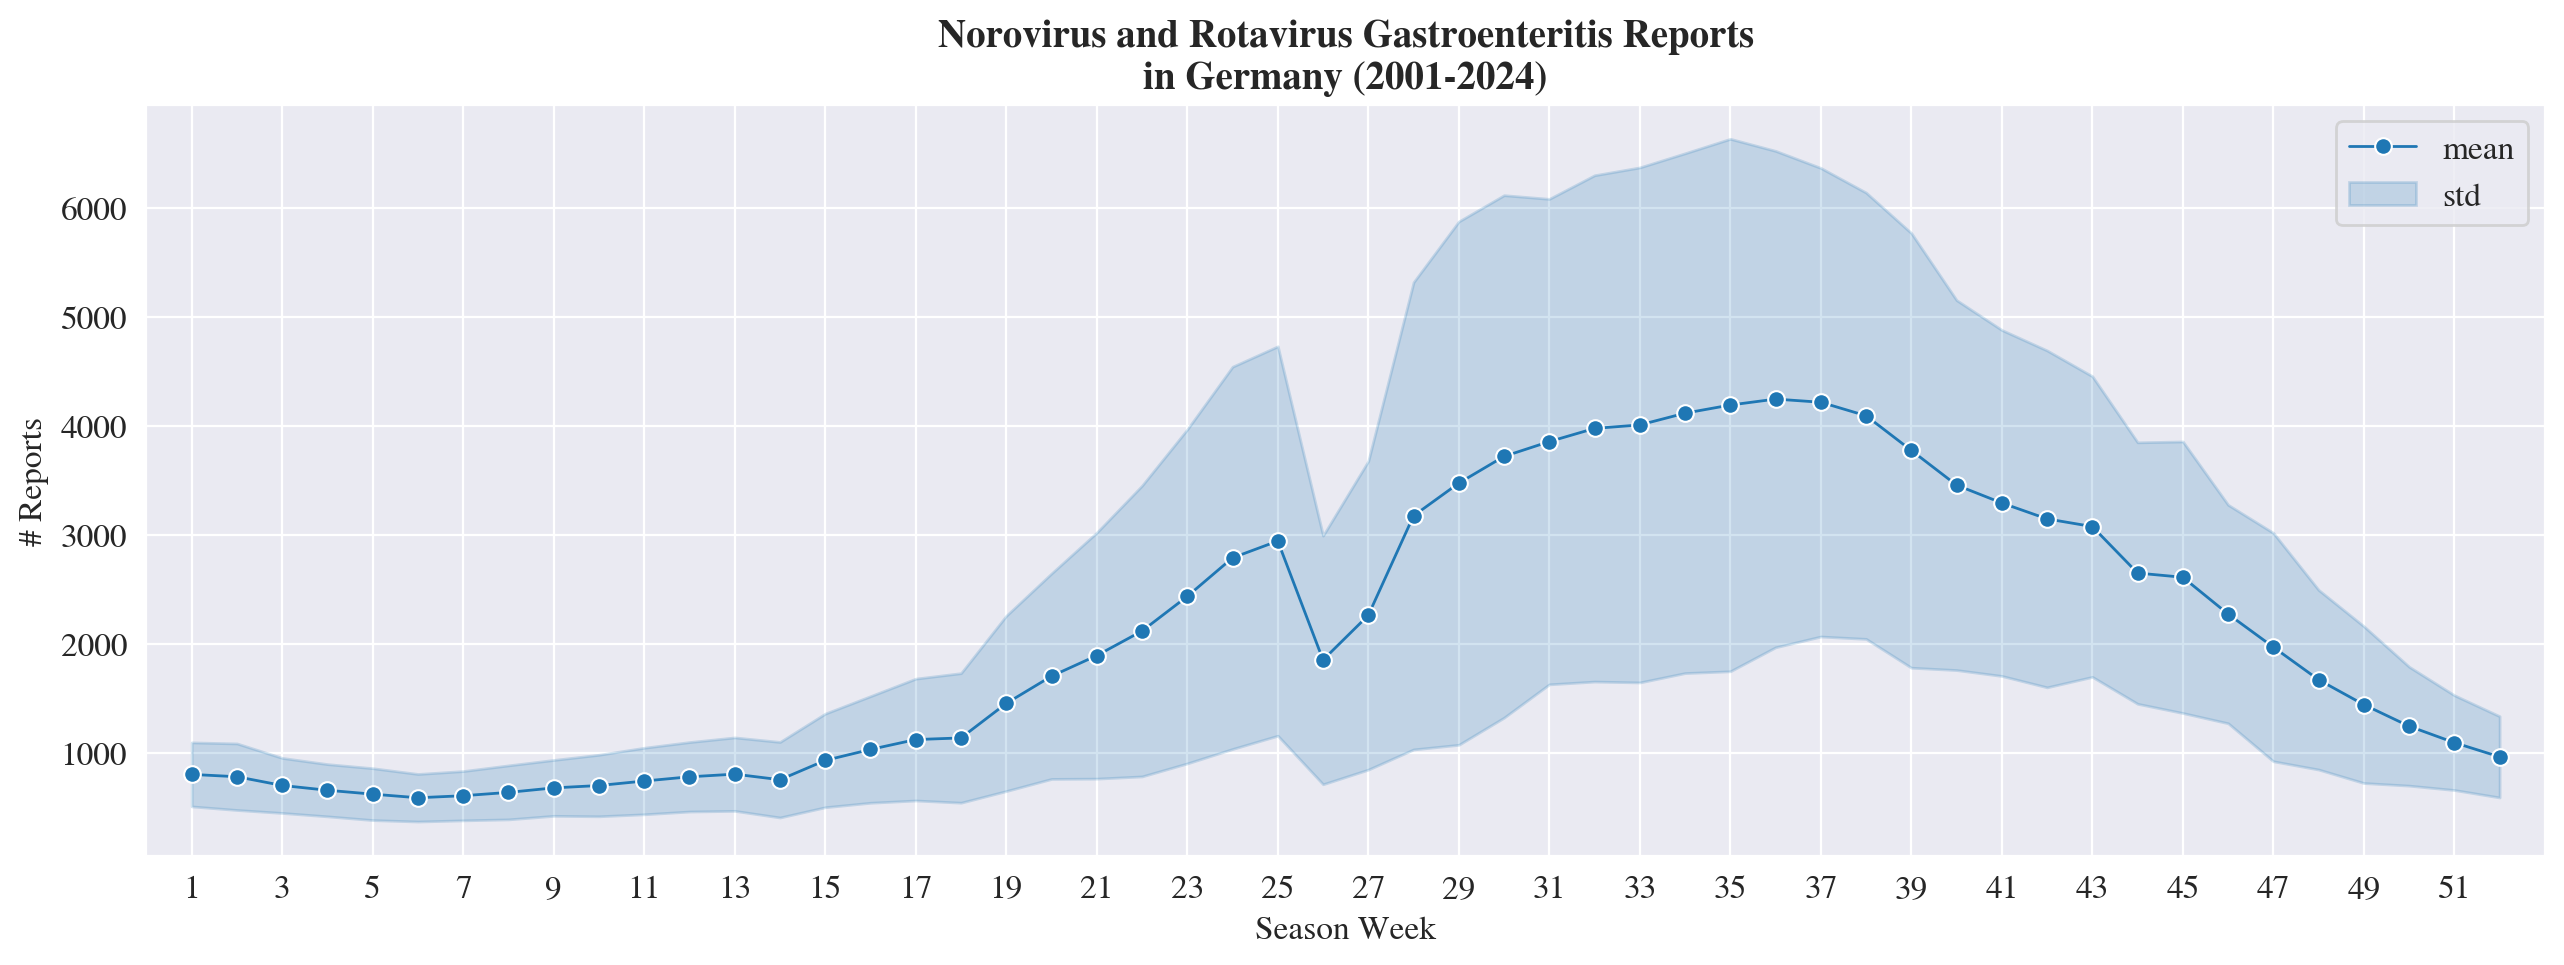

In [193]:
# Plot Aggregation of all + uncertainty (test std and confidence intervals)
fig, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(
    data=df_cleaned.sort_values("seasonWeek"),
    x="seasonWeek",
    y="reports",
    ax=ax,
    errorbar="sd",
    label="mean",
    err_kws={"label": "std"},
    marker="o",
    linewidth=1,
)
ax.set(
    title="Norovirus and Rotavirus Gastroenteritis Reports\nin Germany (2001-2024)",
    xlabel="Season Week",
    ylabel="# Reports",
    xlim=(0, 53),
)
plt.xticks(np.arange(1, 53, 2))
plt.tight_layout()
plt.show()

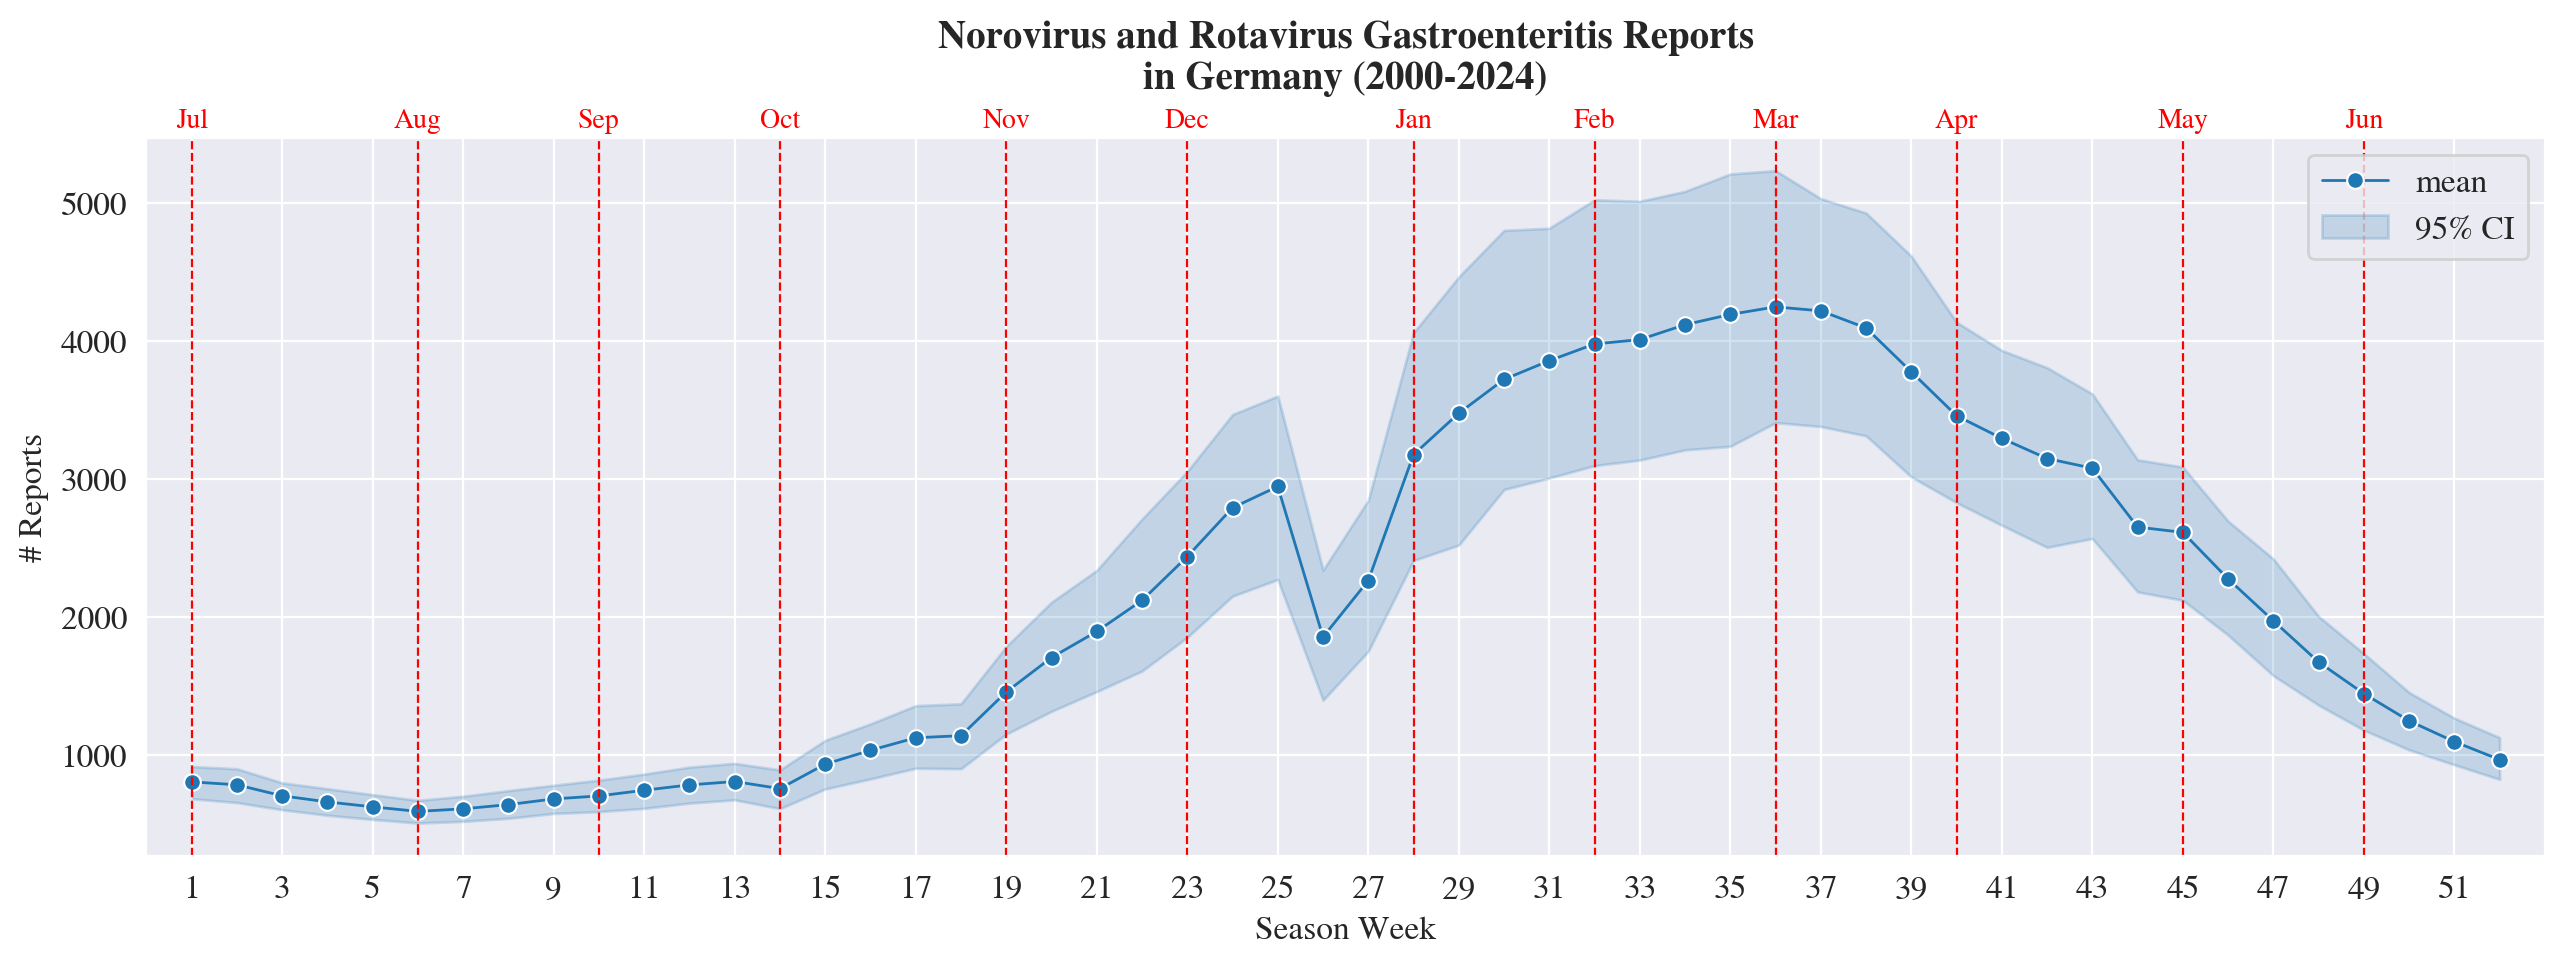

In [194]:
# Plot Aggregation of all + uncertainty (test std and confidence intervals)
fig, ax = plt.subplots(figsize=(13, 5))
# Plot
sns.lineplot(
    data=df_cleaned.sort_values("seasonWeek"),
    x="seasonWeek",
    y="reports",
    ax=ax,
    errorbar=("ci", 95),
    label="mean",
    err_kws={"label": "95% CI"},
    marker="o",
    linewidth=1,
)
# Set labels
ax.set(
    xlabel="Season Week",
    ylabel="# Reports",
    xlim=(0, 53),
)
ax.set_title(
    "Norovirus and Rotavirus Gastroenteritis Reports\nin Germany (2000-2024)", pad=18
)
# Add month markers
df_cleaned["month"] = df_cleaned["week_start_date"].dt.strftime("%b")
unique_months = df_cleaned.groupby("month")["seasonWeek"].first()
for month, week in unique_months.items():
    plt.axvline(week, color="red", linestyle="--", linewidth=0.8)
    plt.text(week, 5550, month, rotation=0, ha="center", fontsize=10, color="red")
# Set x-ticks
plt.xticks(np.arange(1, 53, 2))

plt.tight_layout()
plt.show()

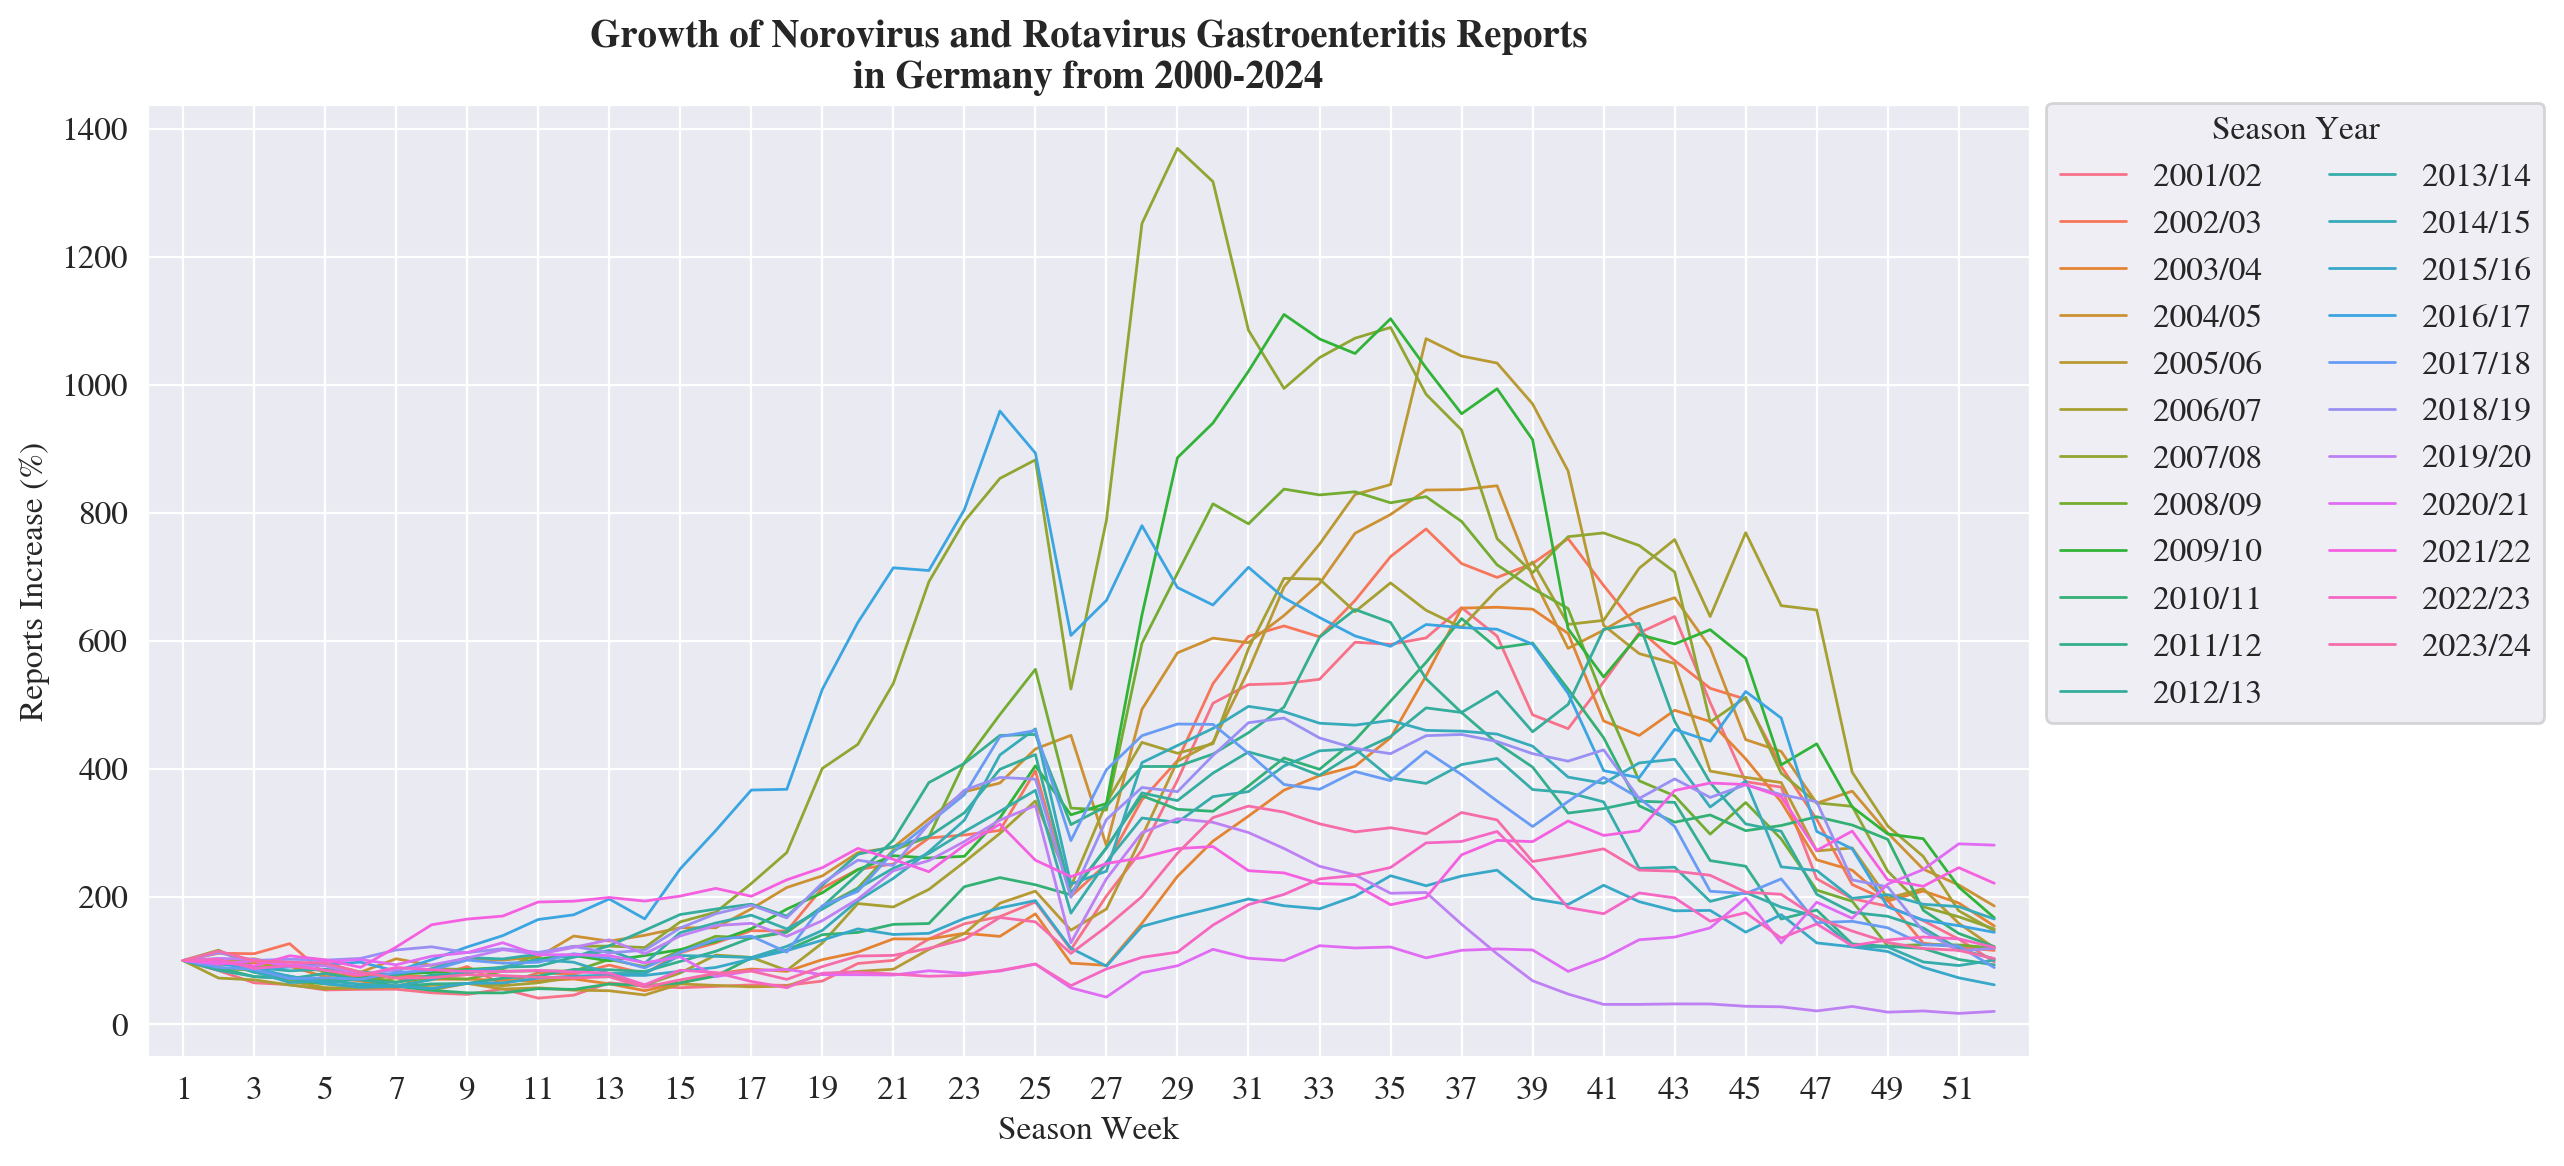

In [195]:
# Plot normalized time series data
df_pivot = df_cleaned.pivot(index="seasonWeek", columns="seasonYear", values="reports")
# Normalize data by first sample: Representing every single data point as the percentage increase relative to the first sample
df_pivot_norm = df_pivot.div(df_pivot.iloc[0]).mul(100)

# Plot
fig, ax = plt.subplots(figsize=(13, 6))
sns.lineplot(data=df_pivot_norm, ax=ax, dashes=False, linewidth=1)
ax.set(
    title="Growth of Norovirus and Rotavirus Gastroenteritis Reports\nin Germany from 2000-2024",
    xlabel="Season Week",
    ylabel="Reports Increase (%)",
    xlim=(0, 53),
)
# Rename legend
ax.legend(title="Season Year", loc="upper left", bbox_to_anchor=(1, 1.02), ncol=2)
# Set x-ticks
plt.xticks(np.arange(1, 53, 2))
plt.tight_layout()
plt.show()

# Seasonal decomposition
Inspect the seasonal decomposition of the time series data and identify peak, mid and low seasonal activity.


In [140]:
df_temp = df_cleaned.copy()
df_temp = df_temp[["seasonWeek", "week_start_date", "reports"]]
df_temp

,seasonWeek,week_start_date,reports
0,1,2001-07-02,430
1,2,2001-07-09,362
2,3,2001-07-16,280
3,4,2001-07-23,268
4,5,2001-07-30,232
...,...,...,...
1213,48,2024-05-27,1560
1214,49,2024-06-03,1370
1215,50,2024-06-10,1269
1216,51,2024-06-17,1238


In [141]:
%%time
# Seasonal decomposition
seasonal_decomposition = seasonal_decompose(
    df_temp["reports"],
    model="additive",
    extrapolate_trend="freq",
    period=52,  # seasonal period
)

CPU times: total: 15.6 ms
Wall time: 1.79 ms


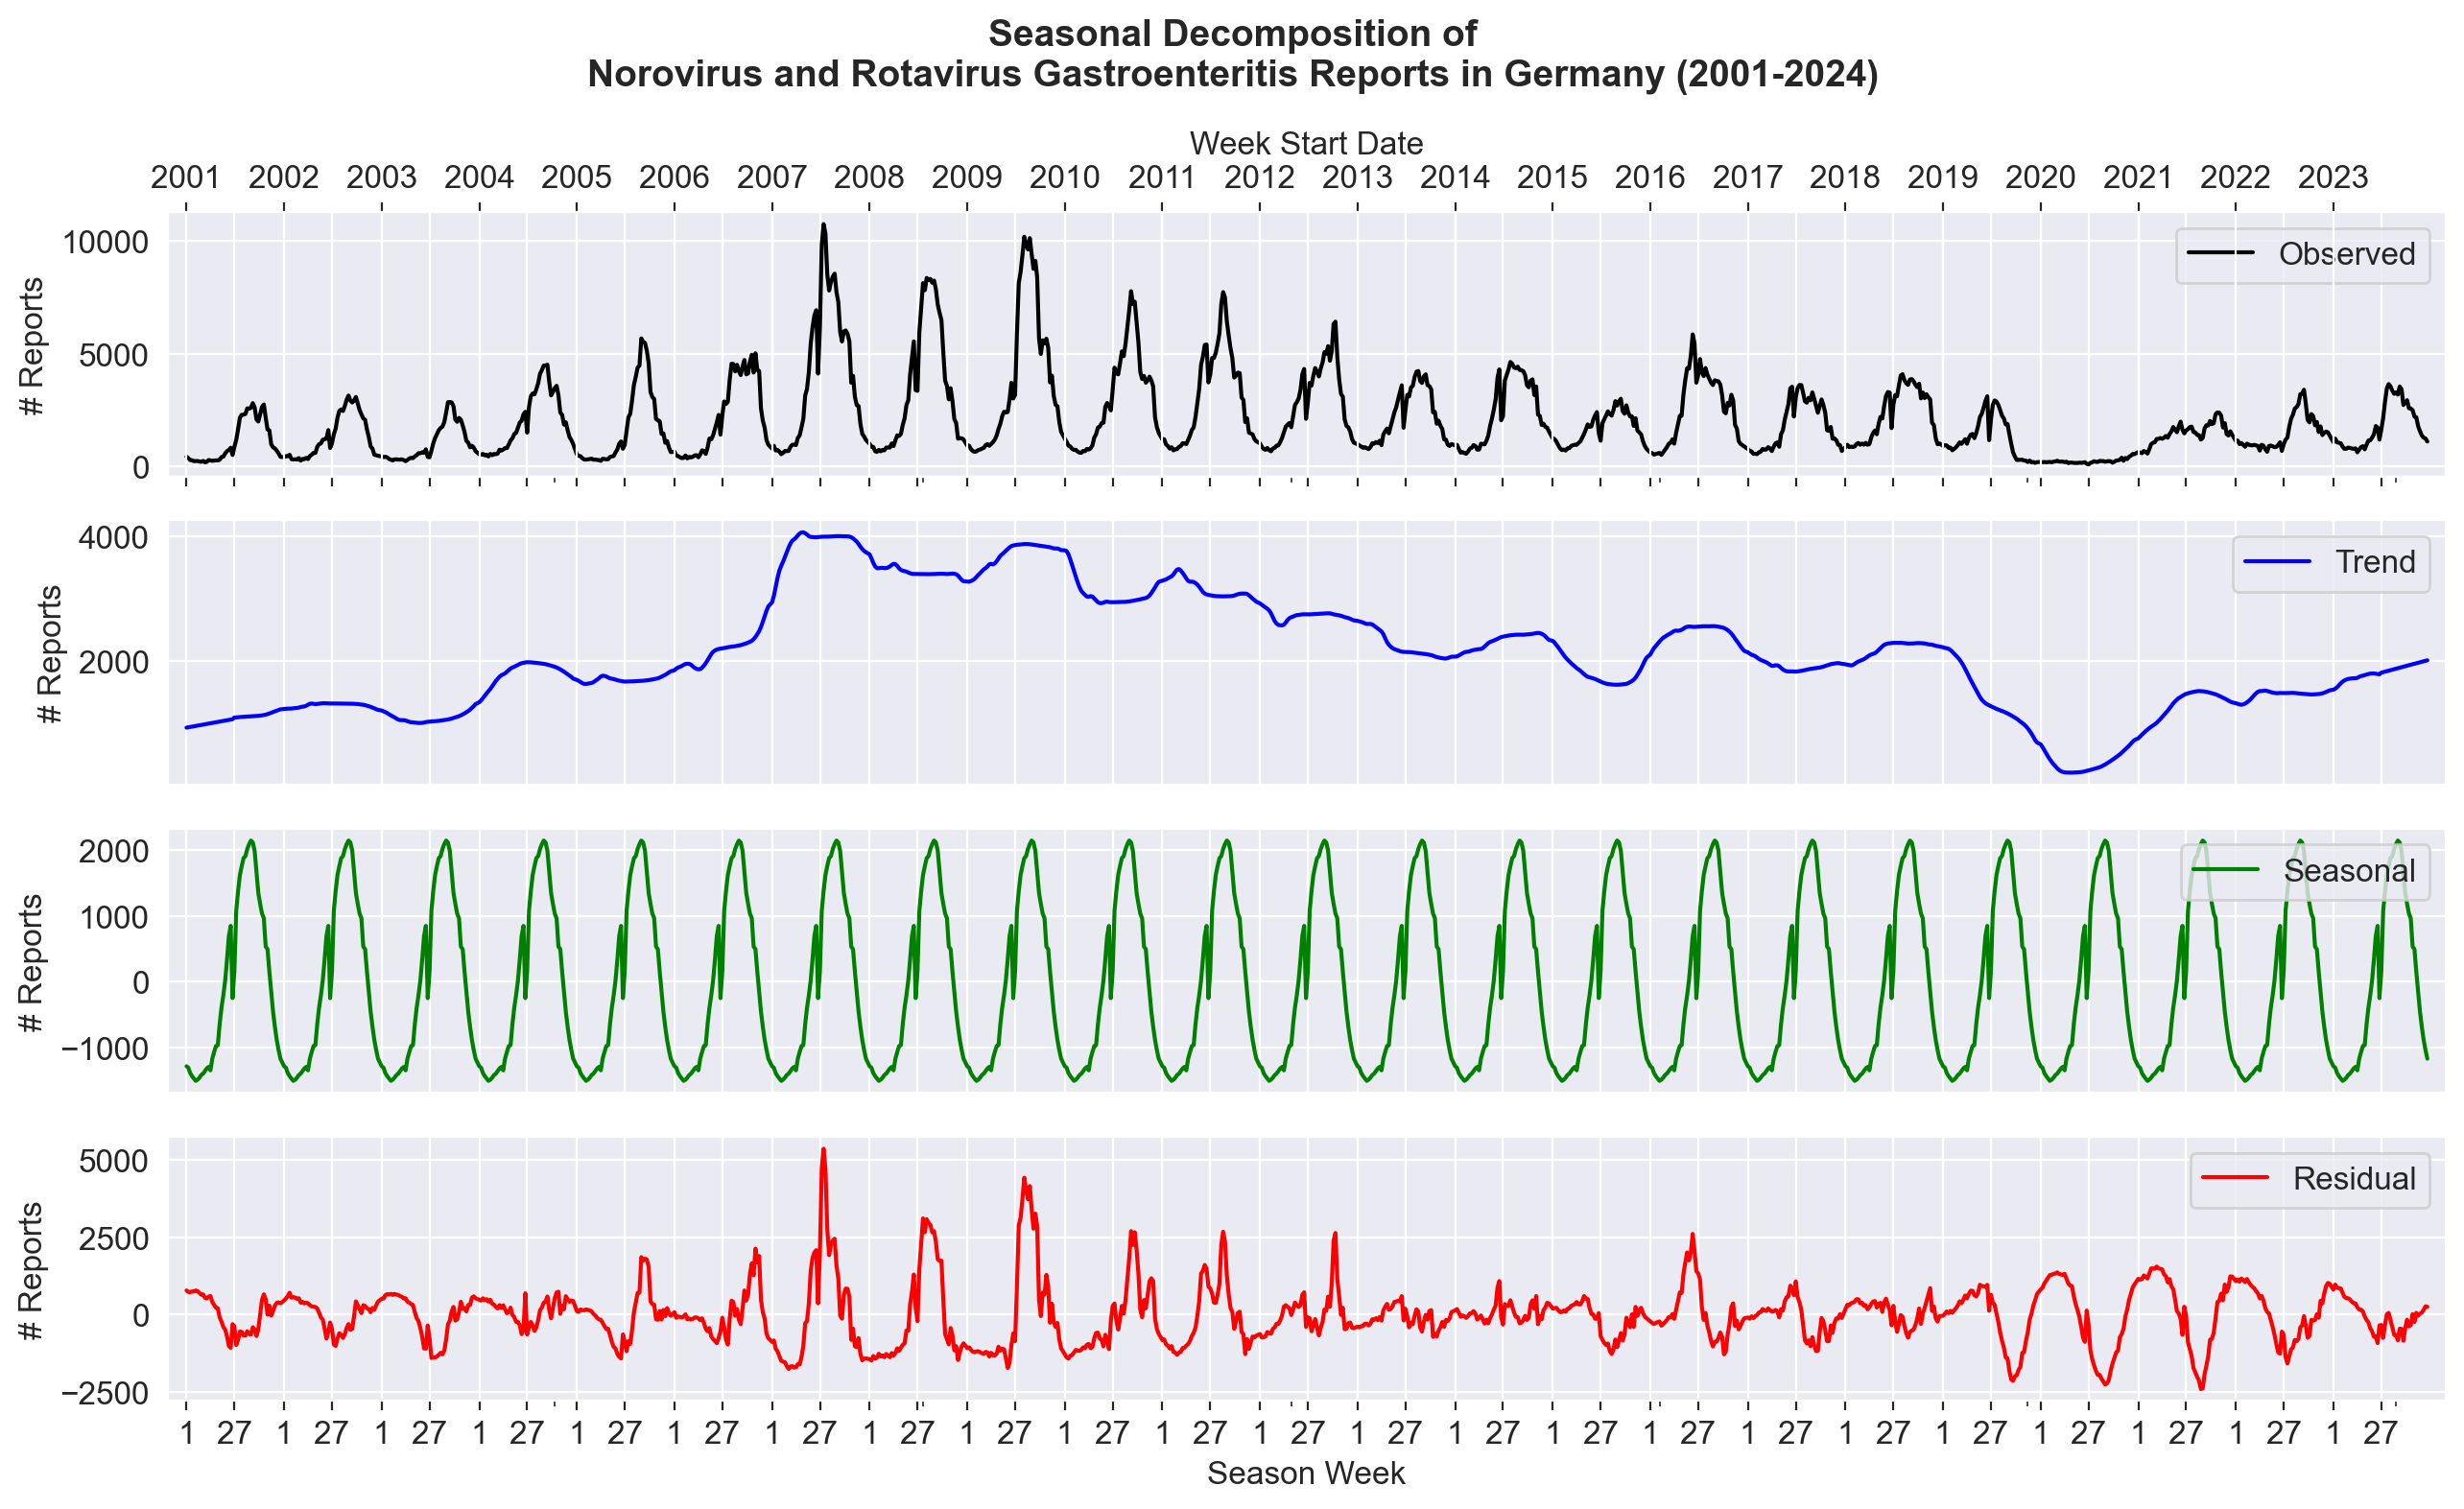

In [216]:
# Plot
fig, axes = plt.subplots(4, 1, figsize=(13, 8), sharex=True)
seasonal_decomposition.observed.plot(ax=axes[0], color="black", label="Observed")
seasonal_decomposition.trend.plot(ax=axes[1], color="blue", label="Trend")
seasonal_decomposition.seasonal.plot(ax=axes[2], color="green", label="Seasonal")
seasonal_decomposition.resid.plot(ax=axes[3], color="red", label="Residual")
# Setting for all axes
for ax in axes:
    ax.legend(loc="upper right")
    ax.set_ylabel("# Reports")
    ax.set_xlim(df_temp.index[0] - 10, df_temp.index[-1] + 10)
# Set x-label to season week
period = 26
axes[3].set_xlabel("Season Week")
axes[3].set_xticks(df_temp.index[::period])
axes[3].set_xticklabels(df_temp["seasonWeek"][::period])
axes[3].xaxis.set_ticks_position("bottom")
# Add secondary x-axis with week start date on top plot
secondary_axis = axes[0].twiny()
secondary_axis.set_xlabel("Week Start Date")
secondary_axis.set_xticks(df_temp.index[:: period * 2])
secondary_axis.set_xticklabels(
    df_temp["week_start_date"].dt.strftime("%Y")[:: period * 2]
)
secondary_axis.xaxis.set_ticks_position("top")
secondary_axis.set_xlim(axes[0].get_xlim())
# Set tight layout
fig.suptitle(
    "Seasonal Decomposition of\nNorovirus and Rotavirus Gastroenteritis Reports in Germany (2001-2024)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()